In [20]:
import pandas as pd
import sqlalchemy as sal
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
load_dotenv()

# Create a connection to the database
server_database = os.getenv("SERVER_DATABASE")
# SERVER_DATABASE variable contain string with the following format: "server_name/database_name"

engine = sal.create_engine(f'mssql+pyodbc://@{server_database}?trusted_connection=yes&driver=SQL+Server')
conn = engine.connect()

### Mapping Problem with condition_ancestor tables

From athena website choose to use SNOMED 201826 as a code
(Which is equivalent to "E11" ICD10)

In [21]:
## Recursive 
sql = """
WITH des AS (
SELECT c.descendant_concept_id
FROM vocab.concept_ancestor c
WHERE c.ancestor_concept_id = 201826
UNION ALL
SELECT ca.descendant_concept_id
FROM vocab.concept_ancestor ca
JOIN des ON des.descendant_concept_id = ca.ancestor_concept_id
WHERE ca.ancestor_concept_id != ca.descendant_concept_id
)
SELECT DISTINCT descendant_concept_id
FROM des
ORDER BY descendant_concept_id
"""
recur_d = pd.read_sql(sql,conn)
recur_d

,descendant_concept_id
0,201826
1,766253
2,4063043
3,4099651
4,4129519
5,4130162
6,4193704
7,4230254
8,4304377
9,36684827


In [22]:
sql = '''
SELECT c.ancestor_concept_id, c.descendant_concept_id
FROM vocab.concept_ancestor c
WHERE c.ancestor_concept_id = 201826 -- base query
ORDER BY c.descendant_concept_id
'''
descendant = pd.read_sql(sql, conn)
descendant

,ancestor_concept_id,descendant_concept_id
0,201826,201826
1,201826,766253
2,201826,4063043
3,201826,4099651
4,201826,4129519
5,201826,4130162
6,201826,4193704
7,201826,4230254
8,201826,4304377
9,201826,36684827


### But from data mining
Using ICD10 E11* as a search key

In [23]:
sql ='''
WITH icd AS (
SELECT co.condition_source_value, co.condition_concept_id
FROM [cdm].[condition_occurrence] co
WHERE LEFT(co.condition_source_value,3) = 'E11'
)

SELECT DISTINCT c.concept_id, c.concept_name, i.condition_source_value
FROM [vocab].[concept] c
INNER JOIN icd i ON c.concept_id = i.condition_concept_id
ORDER BY c.concept_id
'''

descendant_icd = pd.read_sql(sql, conn)
descendant_icd

,concept_id,concept_name,condition_source_value
0,201826,Type 2 diabetes mellitus,E110
1,201826,Type 2 diabetes mellitus,E11
2,376065,Disorder of nervous system due to type 2 diabe...,E114
3,443729,Peripheral circulatory disorder due to type 2 ...,E115
4,443731,Renal disorder due to type 2 diabetes mellitus,E112
5,443732,Disorder due to type 2 diabetes mellitus,E117
6,443732,Disorder due to type 2 diabetes mellitus,E116
7,443732,Disorder due to type 2 diabetes mellitus,E118
8,443733,Disorder of eye due to type 2 diabetes mellitus,E113
9,443734,Ketoacidosis due to type 2 diabetes mellitus,E111


In [24]:
code_icd = set(descendant_icd['concept_id'].unique())
code_concept = set(descendant['descendant_concept_id'].unique())

In [25]:
print("Code from ICD searching:", code_icd)
print("Code from concept_ancestor:", code_concept)

print("Code not in concept_ancestor:", code_icd - code_concept)

Code from ICD searching: {376065, 201826, 4193704, 443729, 443731, 443732, 443733, 443734, 443735}
Code from concept_ancestor: {201826, 4063043, 4099651, 43531010, 45757474, 45766052, 4193704, 766253, 4230254, 4129519, 4130162, 4304377, 36684827}
Code not in concept_ancestor: {376065, 443729, 443731, 443732, 443733, 443734, 443735}


In [26]:
sql = f"""
SELECT c.concept_id, c.concept_name
FROM vocab.concept c
WHERE c.concept_id IN (376065, 443729, 443731, 443732, 443733, 443734, 443735)
"""

missed_code_name = pd.read_sql(sql, conn)
missed_code_name

,concept_id,concept_name
0,443732,Disorder due to type 2 diabetes mellitus
1,443735,Coma due to diabetes mellitus
2,443733,Disorder of eye due to type 2 diabetes mellitus
3,443729,Peripheral circulatory disorder due to type 2 ...
4,443734,Ketoacidosis due to type 2 diabetes mellitus
5,443731,Renal disorder due to type 2 diabetes mellitus
6,376065,Disorder of nervous system due to type 2 diabe...


### Different in patients number

In [27]:
# from OMOP concept ancestor code
sql = """
WITH desc_con AS ( -- All descendants of the 201826 T2DM SNOMED concept
    SELECT c.descendant_concept_id
    FROM vocab.concept_ancestor c
    WHERE c.ancestor_concept_id = 201826 -- base query 
),

p_info AS ( -- Get patients info
    SELECT p.person_id, p.year_of_birth
    FROM cdm.person p
),

diag_info AS ( -- get the first diagnosis of T2DM for each patient
    SELECT  co.person_id,
            co.condition_concept_id,
            MIN(co.condition_start_datetime) AS first_diag,
            ROW_NUMBER() OVER(PARTITION BY co.person_id ORDER BY co.condition_start_datetime) as rn
    FROM cdm.condition_occurrence co
    JOIN desc_con d ON co.condition_concept_id = d.descendant_concept_id
    WHERE co.condition_start_datetime > '2013-06-01'
    AND co.condition_start_datetime < '2023-09-30'
    GROUP BY co.person_id, co.condition_concept_id, co.condition_start_datetime
)

SELECT  d.person_id,
        d.condition_concept_id,
        (YEAR(d.first_diag) - p.year_of_birth) AS age_at_first_diag
FROM diag_info d
JOIN p_info p ON d.person_id = p.person_id
WHERE d.rn = 1
"""

patient_concept = pd.read_sql(sql, conn)
patient_concept.head()

,person_id,condition_concept_id,age_at_first_diag
0,4445264,4193704,79
1,4409964,4193704,75
2,4445478,4193704,90
3,4445593,4193704,67
4,4445702,4193704,70


In [28]:
print("Check if the person_id column is unique:", patient_concept['person_id'].is_unique)
print("Total number of patients:", patient_concept['person_id'].nunique())

Check if the person_id column is unique: True
Total number of patients: 151629


In [29]:
patient_concept_count = pd.DataFrame(patient_concept['condition_concept_id'].value_counts())

sql = """
SELECT c.concept_id, c.concept_name
FROM vocab.concept c
WHERE c.concept_id IN (4193704, 4063043, 201826)
"""
concept_df = pd.read_sql(sql, conn)

patient_concept_count['concept_desc'] = concept_df['concept_name'].values

patient_concept_count

,count,concept_desc
condition_concept_id,,
4193704,150419,Type 2 diabetes mellitus without complication
4063043,978,Pre-existing type 2 diabetes mellitus
201826,232,Type 2 diabetes mellitus


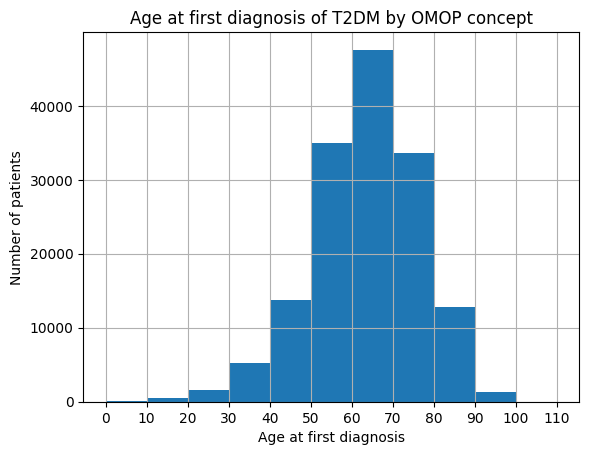

In [30]:
plt.hist(patient_concept['age_at_first_diag'], bins=np.arange(0,120,10))
plt.grid()
plt.xlabel('Age at first diagnosis')
plt.xticks(np.arange(0,120,10))
plt.ylabel('Number of patients')
plt.title('Age at first diagnosis of T2DM by OMOP concept')
plt.show()

In [31]:
sql = """
WITH desc_icd AS (
    SELECT DISTINCT co.condition_concept_id
    FROM [cdm].[condition_occurrence] co
    WHERE LEFT(co.condition_source_value,3) = 'E11'
),

p_info AS ( -- Get patients info
    SELECT p.person_id, p.year_of_birth
    FROM cdm.person p
),

diag_info AS ( -- get the first diagnosis of T2DM for each patient
    SELECT  co.person_id,
            co.condition_concept_id,
            MIN(co.condition_start_datetime) AS first_diag,
            ROW_NUMBER() OVER(PARTITION BY co.person_id ORDER BY co.condition_start_datetime) as rn
    FROM cdm.condition_occurrence co
    JOIN desc_icd d ON co.condition_concept_id = d.condition_concept_id
    WHERE co.condition_start_datetime > '2013-06-01'
    AND co.condition_start_datetime < '2023-09-30'
    GROUP BY co.person_id, co.condition_concept_id, co.condition_start_datetime
)

SELECT  d.person_id,
        d.condition_concept_id,
        (YEAR(d.first_diag) - p.year_of_birth) AS age_at_first_diag
FROM diag_info d
JOIN p_info p ON d.person_id = p.person_id
WHERE d.rn = 1
"""

patient_icd = pd.read_sql(sql, conn)
patient_icd.head()

,person_id,condition_concept_id,age_at_first_diag
0,379167,4193704,74
1,379194,4193704,44
2,379201,4193704,73
3,379204,4193704,46
4,379221,4193704,64


In [32]:
print("Check if the person_id column is unique:", patient_icd['person_id'].is_unique)
print("Total number of patients:", patient_icd['person_id'].nunique())

Check if the person_id column is unique: True
Total number of patients: 155662


In [33]:
patient_icd_count = pd.DataFrame(patient_icd['condition_concept_id'].value_counts())

sql = """
SELECT c.concept_id, c.concept_name
FROM vocab.concept c
WHERE c.concept_id IN (4193704, 443733, 443731, 443732, 376065, 443734, 443729, 443735, 201826)
"""
concept_df = pd.read_sql(sql, conn)

patient_icd_count = patient_icd_count.merge(concept_df, left_index=True, right_on='concept_id')

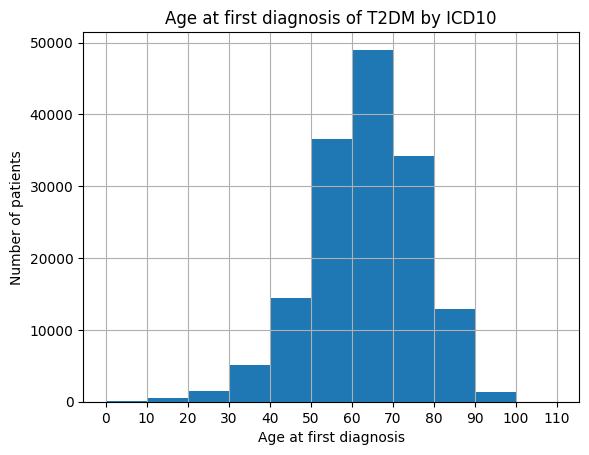

In [34]:
plt.hist(patient_icd['age_at_first_diag'], bins=np.arange(0,120,10))
plt.grid()
plt.xlabel('Age at first diagnosis')
plt.xticks(np.arange(0,120,10))
plt.ylabel('Number of patients')
plt.title('Age at first diagnosis of T2DM by ICD10')
plt.show()

### Comparing both results

In [35]:
patient_concept_count = patient_concept_count.reset_index()
patient_concept_count.columns = ['concept_id', 'count', 'concept_name']
count_df = patient_concept_count.merge(patient_icd_count, on='concept_id', suffixes=('_omop', '_icd'), how='outer')


In [36]:
count_df = count_df.sort_values(by=['count_omop', 'count_icd'], ascending=False)
count_df = count_df[['concept_id', 'count_omop', 'count_icd', 'concept_name_omop', 'concept_name_icd']]

In [37]:
count_df

,concept_id,count_omop,count_icd,concept_name_omop,concept_name_icd
9,4193704,150419.0,142668.0,Type 2 diabetes mellitus without complication,Type 2 diabetes mellitus without complication
8,4063043,978.0,NaN,Pre-existing type 2 diabetes mellitus,NaN
0,201826,232.0,90.0,Type 2 diabetes mellitus,Type 2 diabetes mellitus
5,443733,NaN,8716.0,NaN,Disorder of eye due to type 2 diabetes mellitus
3,443731,NaN,1531.0,NaN,Renal disorder due to type 2 diabetes mellitus
4,443732,NaN,1332.0,NaN,Disorder due to type 2 diabetes mellitus
1,376065,NaN,703.0,NaN,Disorder of nervous system due to type 2 diabe...
6,443734,NaN,320.0,NaN,Ketoacidosis due to type 2 diabetes mellitus
2,443729,NaN,197.0,NaN,Peripheral circulatory disorder due to type 2 ...
7,443735,NaN,105.0,NaN,Coma due to diabetes mellitus


In [38]:
print("Total number of pt. identified by OMOP code:", count_df['count_omop'].sum())
print("Total number of pt. identified by ICD10 code:", count_df['count_icd'].sum())

Total number of pt. identified by OMOP code: 151629.0
Total number of pt. identified by ICD10 code: 155662.0
